# Exploratory Data Analysis и валидация метрик

## Контекст и конфиденциальность
- Анализ выполнен на реальных коммерческих данных продаж зоомагазина за 2025 год.
- Все прямые числовые показатели и суммы скрыты по соображениям конфиденциальности.
- Визуализации и статистика обезличены: используются индексы, лог-шкала или нормализованные значения.
- Ноутбук демонстрирует **методологию проверки данных, выявления артефактов и анализа распределений**, без раскрытия конкретных коммерческих показателей.

### Данные не публикуются. Ноутбук демонстрирует логику обработки


## 1. Импорт библиотек 

In [1]:
# Работа с табличными данными
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style='whitegrid')

## 2. Загрузка данных

In [2]:
# Загрузка очищенного датасета
df = pd.read_csv('../data/sales_2025_cleaned.csv')

In [3]:
# Проверяем размерность датасета
# df.shape

In [4]:
#df.head()
# Вывод строк данных отключён: используется реальная коммерческая выгрузка

## 3. Общее понимание структуры данных

In [5]:
# Типы данных и пропуски 
# df.info()

In [6]:
# Проверка пропусков 
# missing = df.isna().mean().sort_values(ascending=False)
# missing[missing > 0]

**Вывод:** пропуски присутсвуют в расчетных метриках, что связано с особенностями выгрузки. Пропуски в категориальных признаках отсутсвуют.

In [7]:
# Описательная статистика 
# df.describe().T
# Агрегированные статистики не выводятся по соображениям конфиденциальности

**Вывод:** В данных обнаружены аномальные значения процентных показателей (отрицательные и значительно превышающие 100%).


## 4. Анализ объемов продаж

### 4.1 Количество проданных единиц 

In [8]:
# Базовая статистика по количеству проданных единиц 
#df['qty'].describe()

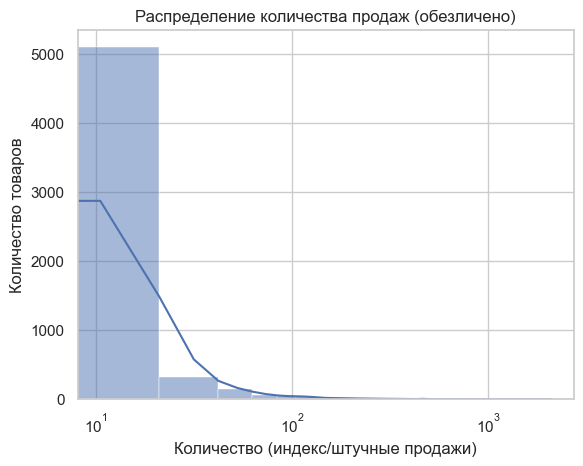

In [9]:
# Гистограмма количества проданных единиц (обезличено)
sns.histplot(df['qty'], bins=100, kde=True)
plt.title('Распределение количества продаж (обезличено)')
plt.xlabel('Количество (индекс/штучные продажи)')
plt.ylabel('Количество товаров')
plt.xscale('log') 
plt.show()

На графике наблюдается сильная правосторонняя асимметрия, связанная с разнымми единицами измерения 

#### Разделение на группы 

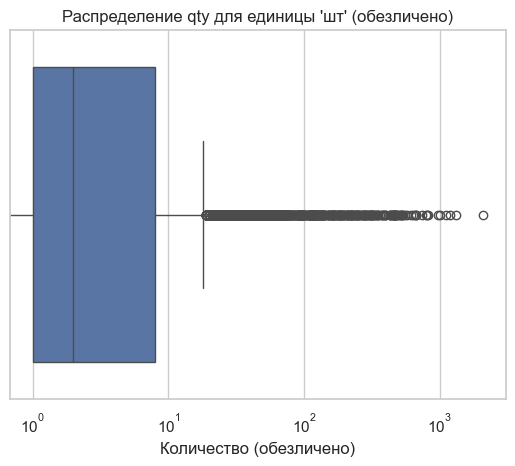

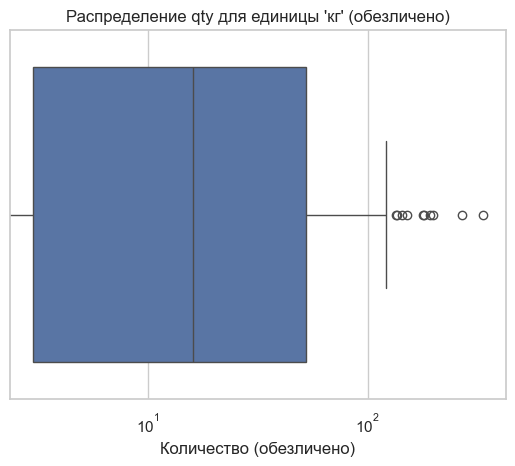

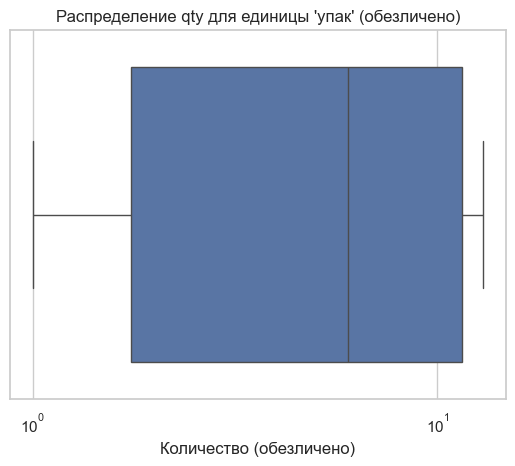

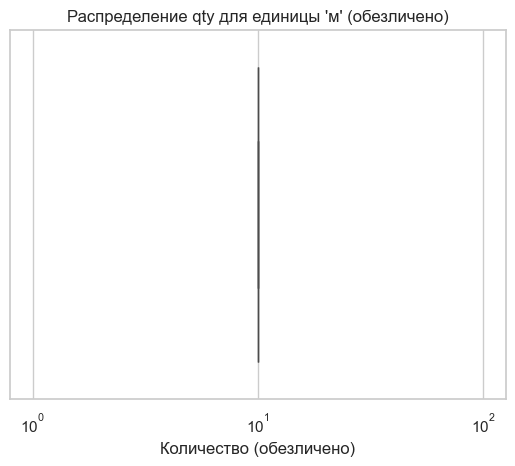

In [10]:
# Разделение по единицам измерения
groups = {unit: df[df['unit'] == unit] for unit in df['unit'].unique()}

for unit, group in groups.items():
    sns.boxplot(x=group['qty'])
    plt.title(f"Распределение qty для единицы '{unit}' (обезличено)")
    plt.xlabel("Количество (обезличено)")
    plt.xscale('log')
    plt.show()

**Вывод:**  
- Штуки: рапсределение сильно скошено, стоит рассмотреть подробнее
- Килограммы: умеренная асимметрия, распределение легко интерпретировать 
- Упаковки: компактное распределение, график наглядный
- Метры: уникальный случай 

#### Количество единиц, проданных поштучно 

In [11]:
# Базовая статистика 
df_units = df[df['unit'] == 'шт']
# df_units['qty'].describe()

In [12]:
# Определяем выбросы
q1 = df_units['qty'].quantile(0.25)
q3 = df_units['qty'].quantile(0.75)

iqr = q3 - q1

# Верхняя граница для выбросов 
upper_bound = q3 + 1.5 * iqr

# Отдельно фиксируем выброссы 
outliers = df_units[df_units['qty'] > upper_bound]

print(f"Верхняя граница IQR (обезличено): {upper_bound / df_units['qty'].median():.2f} медиан")
print(f"Количество выбросов: {len(outliers)}") 

Верхняя граница IQR (обезличено): 9.25 медиан
Количество выбросов: 812


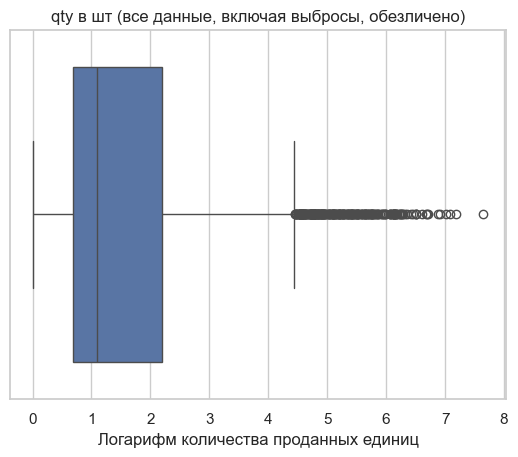

In [13]:
# Boxplot с учетом выбросов 
sns.boxplot(x=np.log1p(df_units['qty'])) 
plt.title("qty в шт (все данные, включая выбросы, обезличено)")
plt.xlabel("Логарифм количества проданных единиц")
plt.show()

**Вывод:** распределение сильно скошено: большинстов товаров продается в малом количестве

### 4.2 Продажи в денежном выражении (обезличено)

In [14]:
# Распределение продаж в денежном выражении
# df['sales_total'].describe()

In [15]:
# Индекс продаж относительно медианы (без раскрытия сумм)
df['sales_index'] = df['sales_total'] / df['sales_total'].median()

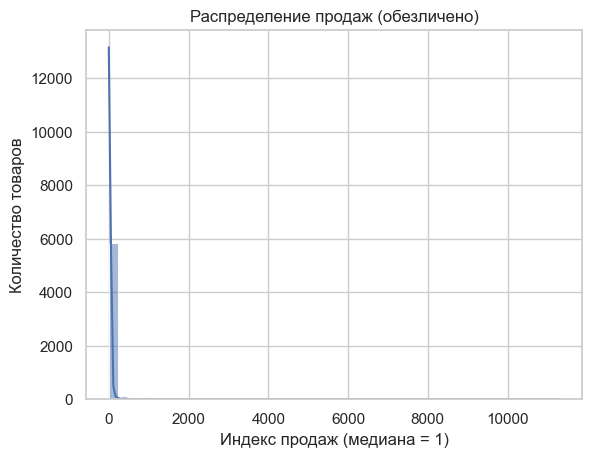

In [16]:
# Гистограмма
sns.histplot(df['sales_index'], bins=50, kde=True)
plt.title('Распределение продаж (обезличено)')
plt.xlabel('Индекс продаж (медиана = 1)')
plt.ylabel('Количество товаров')
plt.show()


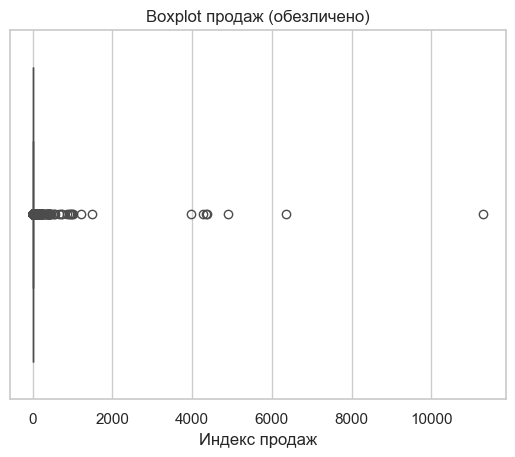

In [17]:
# Boxplot
sns.boxplot(x=df['sales_index'])
plt.title('Boxplot продаж (обезличено)')
plt.xlabel('Индекс продаж')
plt.show()

Boxplot показывает сильную асимметрию: большинство продаж находятся в низком диапазоне,
но присутствуют экстремально большие значения, которые визуально сжимают график.

#### Вывод о выбросах и фиксация артефактов 

In [18]:
# Расчитываем границу для экстремальных выбросов 
q3 = df['sales_total'].quantile(0.75)
q2 = df['sales_total'].quantile(0.25)
iqr = q3 - q1

# Граница для явных артефактов 
artifact_threshold = q3 + 3 * iqr

# Фиксируем найденные артефакты отдельно 
artifacts = df[df['sales_total'] > artifact_threshold]
print(f'Найдено артефактных продаж: {len(artifacts)}')

Найдено артефактных продаж: 604


**Вывод:** Некоторые экстремальные значения явно некорректны и не могут быть реальными по бизнес-логике. Для дальнейшего анализа эти строки хранятся отдельно, но не будут участвовать в расчетах распределения.

#### Вывод по распределению продаж

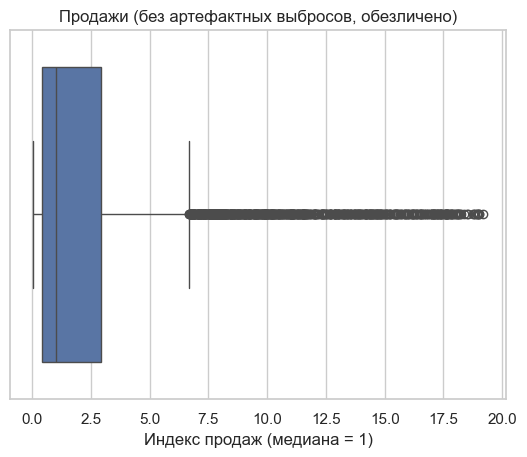

In [19]:
# Датасет без артефактных выбросов
df_clean_sales = df[df['sales_total'] <= artifact_threshold]
df_clean_sales['sales_index'] = df_clean_sales['sales_total'] / df_clean_sales['sales_total'].median()


# Финальный boxplot
sns.boxplot(x=df_clean_sales['sales_index'])
plt.title("Продажи (без артефактных выбросов, обезличено)")
plt.xlabel("Индекс продаж (медиана = 1)")
plt.show()

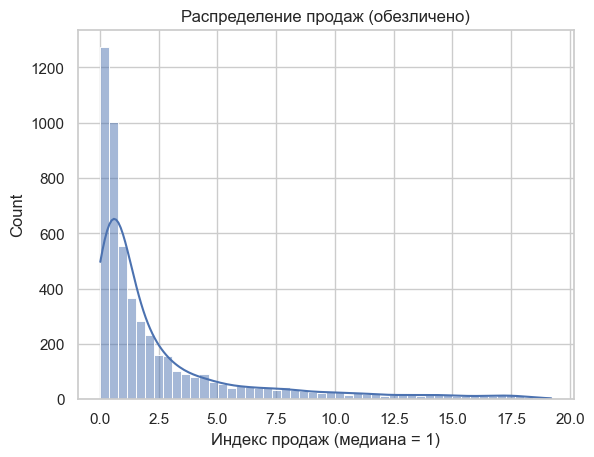

In [20]:
# Финальная гистограмма распределения продаж
sns.histplot(x=df_clean_sales['sales_index'], bins=50, kde=True)
plt.title('Распределение продаж (обезличено)')
plt.xlabel('Индекс продаж (медиана = 1)')
plt.show()

**Вывод:** Распределение выручки сильно скошено вправо, что наводит на гипотезу: **небольшой процент товаров формирует основную долю выручки (эффект Парето)**.

## 5. Отмечаем артефакты

Подход к выявлению артефактов

Артефактами считаются записи, нарушающие базовую бизнес-логику:
- несоответствие продаж и средней цены
- отрицательная маржинальность
- некорректные процентные показатели
- экстремальные значения, не объяснимые бизнес-контекстом

Цель — не удалить данные, а отделить потенциально некорректные записи для оценки масштабов искажений.

In [21]:
# Создаем флаг "is_artifact"
df['is_artifact'] = False

# Артефакты по продажам
df.loc[df['sales_total'] > artifact_threshold, 'is_artifact'] = True

### 5.1 Перерасчет средней цены и оценка расхождений 

In [22]:
# Пересчет средней цены по базовой формуле
df['avg_price_recalc'] = df['sales_total'] / df['qty']

# Относительное отклонение
df['avg_price_diff_pct'] = (
    (df['avg_price'] - df['avg_price_recalc']).abs()
    / df['avg_price_recalc']
)

# df['avg_price_diff_pct'].describe()

In [23]:
# Фиксация артефактов по средней цене 
price_diff_threshold = 0.2  # 20%

df.loc[
    df['avg_price_diff_pct'] > price_diff_threshold,
    'is_artifact'
] = True

### 5.2 Артефакты на основе отрицательной маржинальности

In [24]:
# Добавляем артефакты по отрицательной марже (не отражают реальные финансовые потери)
df.loc[df['margin_pct'] < 0, 'is_artifact'] = True


### 5.3 Артефакты на основе других показателей

In [25]:
# Артефакты по наценке (слишком высокие или отрицательные)
df.loc[(df['markup_pct'] < 0) | (df['markup_pct'] > 500), 'is_artifact'] = True

# Артефакты по доле себестоимости (некорректные проценты)
df.loc[(df['cost_share_pct'] < 0) | (df['cost_share_pct'] > 100), 'is_artifact'] = True

# Артефакты по сумме продаж без скидки (слишком большие отклонения)
df['sales_diff_pct'] = ((df['sales_total_no_discount'] - df['sales_total']).abs()
                        / df['sales_total'])
df.loc[df['sales_diff_pct'] > 1, 'is_artifact'] = True  # >100% отклонение

# Возвраты
df['returns_sales_ratio'] = (
    df['sales_total_with_returns'] / df['sales_total']
)
df.loc[
    df['returns_sales_ratio'] > 1.5, 
    'is_artifact'
] = True


### 5.3 Формирование поднабора корректных данных

In [26]:
df_valid = df[df['is_artifact'] == False].copy()
#df_valid.shape

In [27]:
total_sales_all = df['sales_total'].sum()
total_sales_valid = df_valid['sales_total'].sum()

coverage_pct = total_sales_valid / total_sales_all * 100
coverage_pct

np.float64(1.7529794723700163)

### Масштаб выявленных артефактов
  
После поэтапной валидации ключевых показателей (выручка, средняя цена, маржинальность, наценка, доля себестоимости, продажи без скидки, возвраты) 
и исключения явных артефактов в поднаборе корректных данных осталось 16% от исходного датасета.  

Это демонстрирует, что исходная выгрузка содержит значительное количество некорректных или противоречивых записей, которые могут исказить анализ.  


## 6. Анализ средних цен

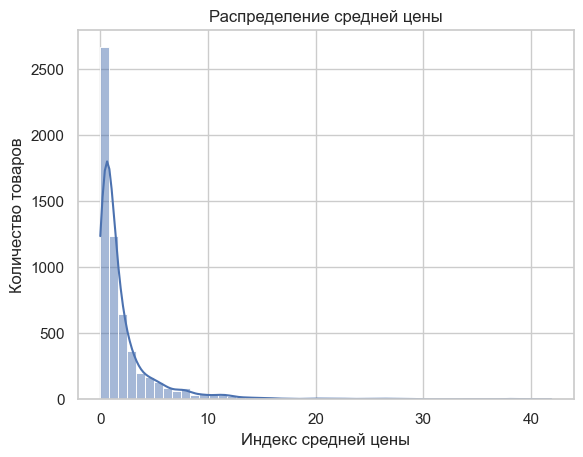

In [28]:
# Индекс средней цены относительно медианы (без раскрытия сумм)
df['avg_price_index'] = df['avg_price'] / df['avg_price'].median()

# Распределение средней цены продажи 
sns.histplot(df['avg_price_index'], bins=50, kde=True)

plt.title('Распределение средней цены')
plt.xlabel('Индекс средней цены')
plt.ylabel('Количество товаров')

plt.show()

In [29]:
# Статистика по средней цене
# df['avg_price'].describe()

**Вывод:**
- Гистограмма средней цены показывает **правостороннюю асимметрию**: большинство товаров находится в низком ценовом диапазоне, при этом есть отдельные дорогие позиции.  
- Экстремальные значения средней цены могут быть связаны с выявленными артефактами.

### Анализ распределения средней цены без учета артефактов

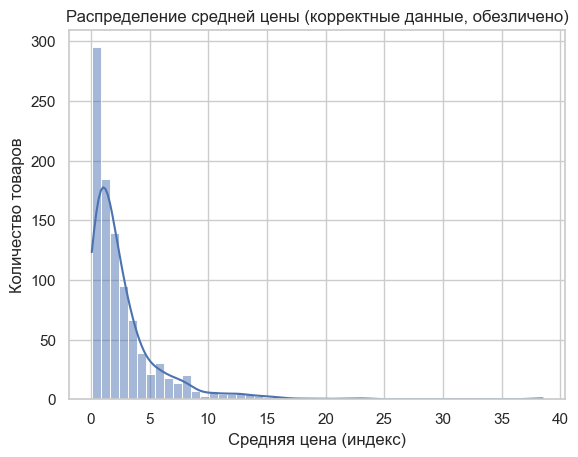

In [30]:
df_valid['avg_price_index'] = df['avg_price_index']
# Гистограмма на основе корректных данных
sns.histplot(df_valid['avg_price_index'], bins=50, kde=True)
plt.title("Распределение средней цены (корректные данные, обезличено)")
plt.xlabel("Средняя цена (индекс)")
plt.ylabel("Количество товаров")
plt.show()

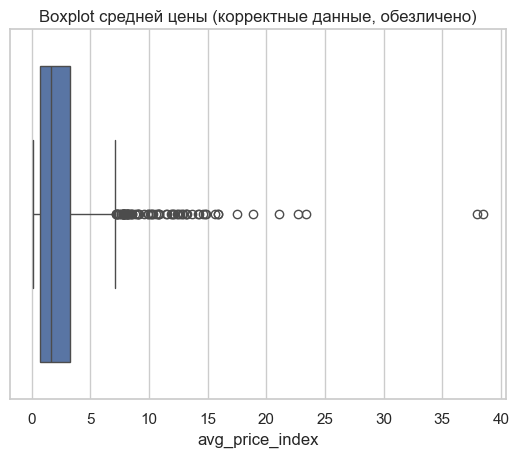

In [31]:
# Boxplot
sns.boxplot(x=df_valid['avg_price_index'])
plt.title("Boxplot средней цены (корректные данные, обезличено)")
plt.show()

In [32]:
# df_valid['avg_price_recalc'].describe()

**Вывод:** После исключения артефактных наблюдений распределение средней цены остается правосторонне скошенным, что типично для товарных ассортиментов с большим числом низкоценовых позиций и ограниченным количеством дорогих товаров.

## 7. Анализ маржинальности 

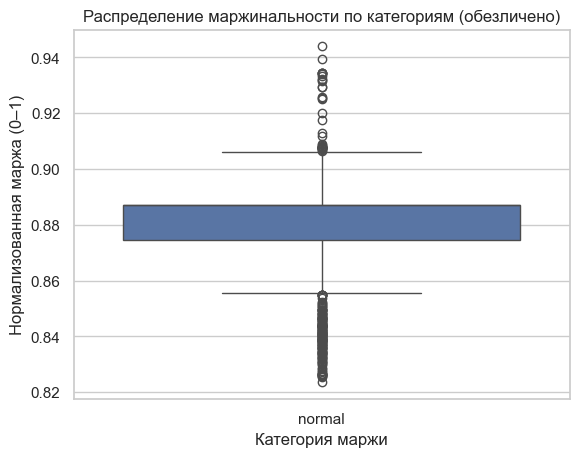

In [33]:
# Нормализуем маржу от 0 до 1 для обезличивания
df['margin_norm'] = (df['margin_pct'] - df['margin_pct'].min()) / (df['margin_pct'].max() - df['margin_pct'].min())

# Создаем категорию для визуализации (нормальная / отрицательная)
df['margin_type'] = 'normal'
df.loc[(df['margin_pct'] < 0) & (~df['is_artifact']), 'margin_type'] = 'negative'

# Визуализация распределения маржи (обезличено)
sns.boxplot(
    x='margin_type', 
    y='margin_norm', 
    data=df[df['is_artifact'] == False]
)
plt.title("Распределение маржинальности по категориям (обезличено)")
plt.xlabel("Категория маржи")
plt.ylabel("Нормализованная маржа (0–1)")
plt.show()

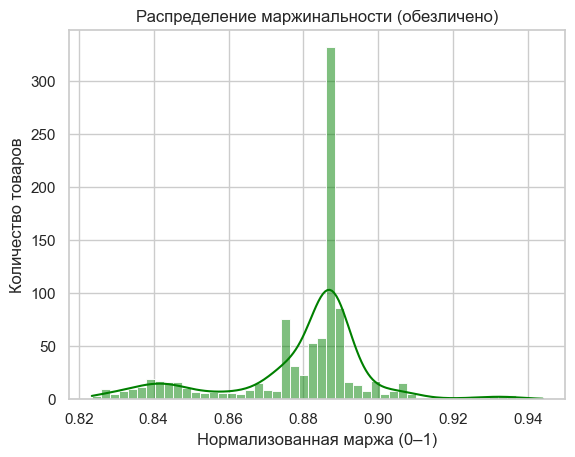

In [34]:
# Гистограмма распределения нормализованной маржи
sns.histplot(df[df['is_artifact'] == False]['margin_norm'], bins=50, kde=True, color='green')
plt.title("Распределение маржинальности (обезличено)")
plt.xlabel("Нормализованная маржа (0–1)")
plt.ylabel("Количество товаров")
plt.show()

**Вывод:** 
- Распределение маржинальности после исключения артефактных данных имеет чёткую концентрацию вокруг среднего значения.
- Существуют отдельные товары с относительно низкой и высокой маржинальностью, но большинство наблюдений находится в среднем диапазоне.
- Такая картина подтверждает, что после очистки данных основная масса товаров демонстрирует устойчивую и умеренную маржинальность.

## 8. Сохранение датасета 

In [35]:
## Удаление вычислительных колонок 
df.drop(columns=['sales_diff_pct','avg_price_diff_pct'], inplace=True)

df.to_csv('../data/sales_2025_after_EDA.csv')

## Вывод

После поэтапной валидации ключевых показателей корректными остались ~16.5% записей, покрывающих ~2% выручки.

При таком уровне искажений дальнейший анализ ассортимента, цен и прибыли не может дать надежных бизнес-выводов. **Проект остановлен на этапе EDA.**

